# Trabajo Práctico 3

## 1. Construya una red de Kohonen de 2 entradas que aprenda una distribución uniforme dentro del círculo unitario. Mostrar el mapa de preservación de topología. Probar con distribuciones uniformes dentro de otras figuras geométricas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Para reproducibilidad
np.random.seed(42)


### Generación de datos en figuras geométricas

Esta celda define tres funciones para muestrear puntos en distintas regiones del plano, que luego se usan como datos de entrada para entrenar el mapa de Kohonen.

---

#### Círculo unitario

La función `sample_uniform_circle` genera puntos uniformemente distribuidos en el disco unitario:

$$
x^2 + y^2 \le 1.
$$

Para obtener uniformidad en área, no se elige el radio $r$ de forma uniforme, sino como

$$
r = \sqrt{U}, \quad U \sim \mathcal{U}(0,1),
$$

mientras que el ángulo $\theta$ se toma uniforme en $[0, 2\pi)$. Luego cada punto se construye como

$$
x = r \cos\theta, \qquad y = r \sin\theta.
$$

---

#### Cuadrado

La función `sample_uniform_square` genera puntos en el cuadrado

$$
[-1,1] \times [-1,1]
$$

muestreando de manera independiente

$$
x \sim \mathcal{U}(-1,1), \qquad y \sim \mathcal{U}(-1,1),
$$

lo que produce una distribución uniforme en toda el área del cuadrado.

---

#### Triángulo equilátero

La función `sample_uniform_triangle` genera puntos uniformes en un triángulo equilátero definido por los vértices

$$
A = (-1, 0), \quad B = (1, 0), \quad C = \left(0, \sqrt{3}\right).
$$

Se utilizan coordenadas baricéntricas: se toman $u, v \sim \mathcal{U}(0,1)$ y se reflejan cuando $u + v > 1$ para asegurar que

$$
u + v \le 1.
$$

Cada punto se obtiene como combinación convexa de los vértices:

$$
P = A + u(B - A) + v(C - A),
$$

lo que garantiza una distribución uniforme en el interior del triángulo.


In [2]:
def sample_uniform_circle(n_samples: int) -> np.ndarray:
    """
    Genera puntos uniformes dentro del círculo unitario (x^2 + y^2 <= 1).

    Importante: para que sea uniforme en área, el radio se toma como r = sqrt(U),
    con U ~ Uniform(0,1).
    """
    u = np.random.rand(n_samples)
    r = np.sqrt(u)  # uniformidad en área
    theta = 2 * np.pi * np.random.rand(n_samples)

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    return np.stack([x, y], axis=1)


def sample_uniform_square(n_samples: int) -> np.ndarray:
    """
    Genera puntos uniformes en el cuadrado [-1, 1] x [-1, 1].
    """
    x = np.random.uniform(-1, 1, size=n_samples)
    y = np.random.uniform(-1, 1, size=n_samples)
    return np.stack([x, y], axis=1)


def sample_uniform_triangle(n_samples: int) -> np.ndarray:
    """
    Genera puntos uniformes en un triángulo equilátero con vértices:
    A = (-1, 0), B = (1, 0), C = (0, sqrt(3)).

    Se usa muestreo uniforme con coordenadas baricéntricas.
    """
    A = np.array([-1.0, 0.0])
    B = np.array([ 1.0, 0.0])
    C = np.array([ 0.0, np.sqrt(3.0)])

    u = np.random.rand(n_samples)
    v = np.random.rand(n_samples)

    # Reflejo para asegurar que u + v <= 1 (uniforme en el triángulo)
    mask = (u + v > 1.0)
    u[mask] = 1.0 - u[mask]
    v[mask] = 1.0 - v[mask]

    points = (
        A[None, :]
        + u[:, None] * (B - A)[None, :]
        + v[:, None] * (C - A)[None, :]
    )
    return points


### Implementación del mapa de Kohonen 2D (`SOM2D`)

Esta clase implementa desde cero un **mapa autoorganizado de Kohonen (SOM)** bidimensional usando únicamente `numpy`. La grilla de neuronas es de tamaño $m \times n$ y cada neurona tiene un vector de pesos de dimensión `input_dim` (en este trabajo, `input_dim = 2`).

---

#### Estructura de la red e inicialización

En el constructor `__init__`, se fijan:

- El tamaño de la grilla $(m, n)$.
- El número total de iteraciones de entrenamiento `n_iterations`.
- La tasa de aprendizaje inicial $\alpha_0$.
- El radio de vecindad inicial $\sigma_0$ (por defecto, $\sigma_0 \approx \max(m,n)/2$).

Los pesos se inicializan aleatoriamente en el rango $[-1, 1]$ para cada neurona, y se almacenan en un tensor de forma $(m, n, \text{input\_dim})$. Además, se guardan las coordenadas de cada neurona en la grilla:

$$
\text{grid}[i,j] = (i,j).
$$

---

#### Decaimiento de la tasa de aprendizaje y del radio de vecindad

Las funciones internas `_decay_alpha` y `_decay_sigma` implementan un decaimiento exponencial:

$$
\alpha(t) = \alpha_0 \, e^{-t / N}, \qquad
\sigma(t) = \sigma_0 \, e^{-t / N},
$$

donde $N$ es el número total de iteraciones (`n_iterations`) y $t$ es el índice de iteración. De este modo, el aprendizaje comienza siendo global (altos $\alpha$ y $\sigma$) y se vuelve progresivamente más local.

---

#### Unidad de mejor ajuste (BMU)

La función `_find_bmu(x)` calcula la **Best Matching Unit (BMU)** para un vector de entrada $x$:

1. Se computa la distancia euclídea al cuadrado entre $x$ y todos los pesos:
   $$
   d_{ij}^2 = \| x - w_{ij} \|^2.
   $$
2. Se selecciona la neurona $(i^*, j^*)$ que minimiza esta distancia:
   $$
   (i^*, j^*) = \arg\min_{i,j} d_{ij}^2.
   $$

---

#### Regla de entrenamiento

El método `train` recorre `n_iterations` y en cada iteración:

1. Toma una muestra aleatoria $x$ del conjunto de datos.
2. Encuentra la BMU $(i^*, j^*)$.
3. Calcula $\alpha(t)$ y $\sigma(t)$.
4. Evalúa la **función de vecindad gaussiana** entre la BMU y cada neurona $(i,j)$ de la grilla:

   $$
   \Theta_{(i^*,j^*),(i,j)}(t) =
   \exp\left(
     - \frac{\| r_{i^*,j^*} - r_{i,j} \|^2}{2\,\sigma(t)^2}
   \right),
   $$

   donde $r_{i,j} = (i,j)$ son las coordenadas de la neurona en la grilla.

5. Actualiza los pesos de todas las neuronas según la regla de Kohonen:

   $$
   w_{ij}(t+1) = w_{ij}(t)
   + \alpha(t)\,\Theta_{(i^*,j^*),(i,j)}(t)\,\bigl( x - w_{ij}(t) \bigr).
   $$

De este modo, la BMU y sus vecinas en la grilla se mueven hacia el patrón de entrada, preservando la topología: neuronas cercanas en la grilla tienden a especializarse en regiones cercanas del espacio de datos.

---

#### Utilidades

Las funciones `get_weights` y `get_flat_weights` devuelven los pesos aprendidos:

- `get_weights()` retorna un arreglo de forma $(m, n, \text{input\_dim})$.
- `get_flat_weights()` los aplana a $(m \cdot n, \text{input\_dim})$, lo que facilita ciertos gráficos y análisis posteriores.


In [3]:
class SOM2D:
    """
    Implementación desde cero de un mapa autoorganizado de Kohonen (SOM) 2D
    usando únicamente numpy.

    - La grilla de neuronas es de tamaño m x n.
    - Cada neurona tiene un vector de pesos de dimensión `input_dim`.
    - Se usa aprendizaje competitivo con vecindad gaussiana.
    """

    def __init__(
        self,
        m: int,
        n: int,
        input_dim: int = 2,
        n_iterations: int = 10_000,
        alpha0: float = 0.5,
        sigma0: float | None = None,
    ):
        """
        Parámetros:
        -----------
        m, n : tamaño de la grilla (m filas, n columnas)
        input_dim : dimensión de la entrada (en este TP = 2)
        n_iterations : número total de iteraciones de entrenamiento
        alpha0 : tasa de aprendizaje inicial
        sigma0 : radio de vecindad inicial en la grilla.
                 Si es None, se usa max(m, n) / 2.
        """
        self.m = m
        self.n = n
        self.input_dim = input_dim
        self.n_iterations = n_iterations
        self.alpha0 = alpha0
        self.sigma0 = sigma0 if sigma0 is not None else max(m, n) / 2.0

        # Inicialización de pesos en [-1, 1] para cada neurona
        self.weights = np.random.uniform(
            low=-1.0, high=1.0, size=(m, n, input_dim)
        )

        # Coordenadas fijas de cada neurona en la grilla: grid[i, j] = [i, j]
        self.grid = np.array([(i, j) for i in range(m) for j in range(n)])
        self.grid = self.grid.reshape(m, n, 2)

    # ---------- Funciones internas de decaimiento ----------

    def _decay_alpha(self, t: int) -> float:
        """
        Tasa de aprendizaje alpha(t) con decaimiento exponencial.
        """
        return self.alpha0 * np.exp(-t / self.n_iterations)

    def _decay_sigma(self, t: int) -> float:
        """
        Radio de vecindad sigma(t) con decaimiento exponencial.
        """
        return self.sigma0 * np.exp(-t / self.n_iterations)

    # ---------- BMU (Best Matching Unit) ----------

    def _find_bmu(self, x: np.ndarray) -> tuple[int, int]:
        """
        Dado un vector de entrada x (shape = (input_dim,)),
        devuelve los índices (i, j) de la neurona ganadora (BMU).

        La BMU es la neurona cuyo vector de pesos está a menor
        distancia euclídea de x.
        """
        # Diferencia entre x y todos los pesos: broadcasting
        diff = self.weights - x  # shape: (m, n, input_dim)
        dist_sq = np.sum(diff**2, axis=2)  # shape: (m, n)

        # Índice de la mínima distancia
        bmu_index = np.unravel_index(np.argmin(dist_sq), (self.m, self.n))
        return bmu_index

    # ---------- Entrenamiento ----------

    def train(self, data: np.ndarray, verbose: bool = True) -> None:
        """
        Entrena la red con los datos de entrada.

        data: array de shape (N, input_dim)
        verbose: si True, imprime progreso cada cierto número de iteraciones.
        """
        n_samples = data.shape[0]

        for t in range(self.n_iterations):
            # 1. Elegimos una muestra aleatoria del dataset
            x = data[np.random.randint(0, n_samples)]

            # 2. Buscamos la BMU para x
            bmu_i, bmu_j = self._find_bmu(x)

            # 3. Calculamos alpha(t) y sigma(t)
            alpha_t = self._decay_alpha(t)
            sigma_t = self._decay_sigma(t)

            # 4. Calculamos la función de vecindad gaussiana Θ_{u,v}(t)
            bmu_pos = np.array([bmu_i, bmu_j])  # posición de la BMU en la grilla

            # Distancia al cuadrado en la grilla entre cada neurona y la BMU
            diff_grid = self.grid - bmu_pos           # shape: (m, n, 2)
            dist_sq_grid = np.sum(diff_grid**2, axis=2)  # shape: (m, n)

            # Función de vecindad gaussiana
            theta = np.exp(-dist_sq_grid / (2 * (sigma_t**2)))  # shape: (m, n)

            # 5. Actualizamos pesos:
            # w_v(t+1) = w_v(t) + alpha(t)*Θ_{u,v}(t)*(x - w_v(t))
            theta_expanded = theta[..., np.newaxis]  # shape: (m, n, 1)
            self.weights += alpha_t * theta_expanded * (x - self.weights)

            # Mensaje de progreso
            if verbose and (t + 1) % (self.n_iterations // 5) == 0:
                print(
                    f"Iteración {t + 1}/{self.n_iterations} "
                    f"- alpha={alpha_t:.4f}, sigma={sigma_t:.4f}"
                )

    # ---------- Utilidades ----------

    def get_weights(self) -> np.ndarray:
        """
        Devuelve una copia de los pesos actuales del SOM.
        Shape: (m, n, input_dim)
        """
        return self.weights.copy()

    def get_flat_weights(self) -> np.ndarray:
        """
        Devuelve los pesos aplanados como (m*n, input_dim),
        útil para algunos gráficos o análisis.
        """
        return self.weights.reshape(-1, self.input_dim)


### Visualización de la preservación de topología

La función `plot_som_topology` grafica en el plano:

- Los datos de entrenamiento `data` (puntos en $\mathbb{R}^2$).
- Los pesos finales del SOM, organizados en una grilla de tamaño $m \times n$.
- Segmentos que conectan neuronas vecinas en la grilla (abajo y derecha), formando una “malla” deformada.

Si la red de Kohonen preserva la topología, esta malla se adapta a la forma de la distribución de datos (por ejemplo, el círculo unitario), de modo que neuronas vecinas en la grilla $(i,j)$ siguen siendo vecinas en el espacio de entrada, ilustrando la propiedad de **mapa autoorganizado**.


In [4]:
def plot_som_topology(
    som: SOM2D,
    data: np.ndarray,
    title: str = "SOM - preservación de topología",
    data_alpha: float = 0.3,
) -> None:
    """
    Dibuja:
    - Los datos de entrenamiento (puntos en el plano)
    - Los pesos finales del SOM (neuronas)
    - Las conexiones entre neuronas vecinas en la grilla (malla),
      que ilustran la preservación de la topología.

    som : instancia entrenada de SOM2D
    data : array (N, 2) con los datos de entrada
    """
    weights = som.get_weights()   # shape: (m, n, 2)
    m, n, _ = weights.shape

    fig, ax = plt.subplots(figsize=(6, 6))

    # Puntos de datos
    ax.scatter(
        data[:, 0],
        data[:, 1],
        s=5,
        alpha=data_alpha,
        label="Datos de entrenamiento",
    )

    # Neuronas (pesos)
    ax.scatter(
        weights[..., 0].ravel(),
        weights[..., 1].ravel(),
        s=30,
        label="Neuronas (pesos del SOM)",
    )

    # Conectar neuronas vecinas para ver cómo se deforma la grilla
    for i in range(m):
        for j in range(n):
            # vecino abajo
            if i + 1 < m:
                p1 = weights[i, j]
                p2 = weights[i + 1, j]
                ax.plot(
                    [p1[0], p2[0]],
                    [p1[1], p2[1]],
                    linewidth=1,
                )
            # vecino derecha
            if j + 1 < n:
                p1 = weights[i, j]
                p2 = weights[i, j + 1]
                ax.plot(
                    [p1[0], p2[0]],
                    [p1[1], p2[1]],
                    linewidth=1,
                )

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_aspect("equal")
    ax.legend()
    ax.grid(True, alpha=0.2)
    plt.show()




================= Círculo unitario =================

--- Variante: SOM 10x10, iter=5 000, sigma0=5 ---
Iteración 1000/5000 - alpha=0.4094, sigma=4.0945
Iteración 2000/5000 - alpha=0.3352, sigma=3.3523
Iteración 3000/5000 - alpha=0.2745, sigma=2.7446
Iteración 4000/5000 - alpha=0.2247, sigma=2.2471
Iteración 5000/5000 - alpha=0.1840, sigma=1.8398


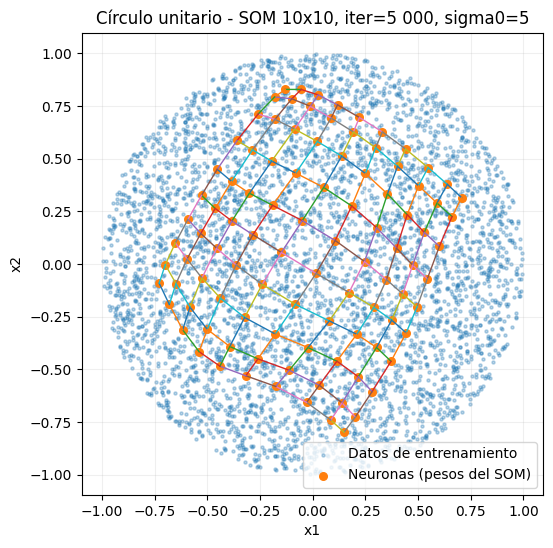


--- Variante: SOM 20x20, iter=10 000, sigma0=10 (baseline) ---
Iteración 2000/10000 - alpha=0.4094, sigma=8.1881
Iteración 4000/10000 - alpha=0.3352, sigma=6.7039
Iteración 6000/10000 - alpha=0.2744, sigma=5.4887
Iteración 8000/10000 - alpha=0.2247, sigma=4.4937
Iteración 10000/10000 - alpha=0.1840, sigma=3.6792


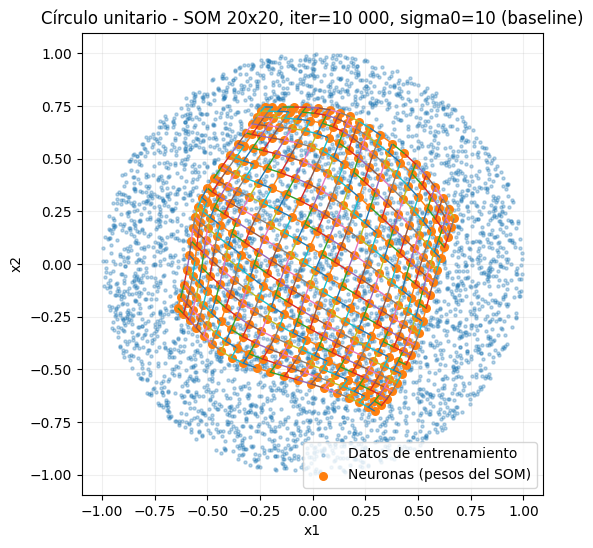


--- Variante: SOM 30x30, iter=15 000, sigma0=12 ---
Iteración 3000/15000 - alpha=0.4094, sigma=9.8254
Iteración 6000/15000 - alpha=0.3352, sigma=8.0444
Iteración 9000/15000 - alpha=0.2744, sigma=6.5862
Iteración 12000/15000 - alpha=0.2247, sigma=5.3923
Iteración 15000/15000 - alpha=0.1840, sigma=4.4148


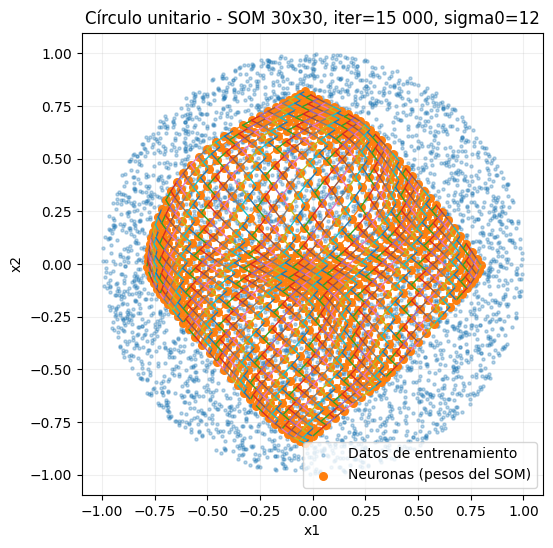



================= Cuadrado [-1,1] x [-1,1] =================

--- Variante: SOM 10x10, iter=5 000, sigma0=5 ---
Iteración 1000/5000 - alpha=0.4094, sigma=4.0945
Iteración 2000/5000 - alpha=0.3352, sigma=3.3523
Iteración 3000/5000 - alpha=0.2745, sigma=2.7446
Iteración 4000/5000 - alpha=0.2247, sigma=2.2471
Iteración 5000/5000 - alpha=0.1840, sigma=1.8398


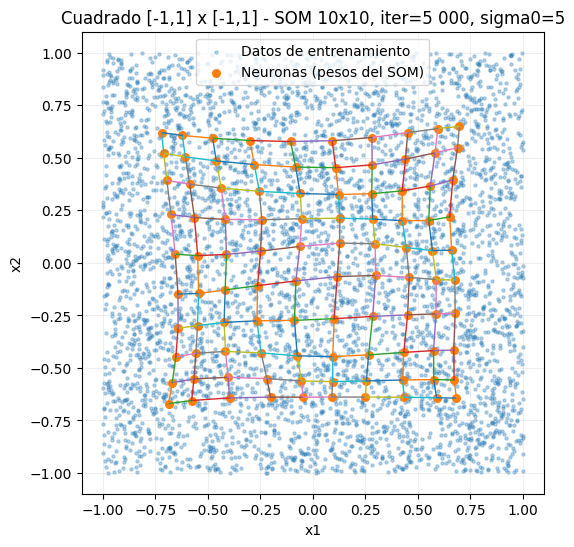


--- Variante: SOM 20x20, iter=10 000, sigma0=10 (baseline) ---
Iteración 2000/10000 - alpha=0.4094, sigma=8.1881
Iteración 4000/10000 - alpha=0.3352, sigma=6.7039
Iteración 6000/10000 - alpha=0.2744, sigma=5.4887
Iteración 8000/10000 - alpha=0.2247, sigma=4.4937
Iteración 10000/10000 - alpha=0.1840, sigma=3.6792


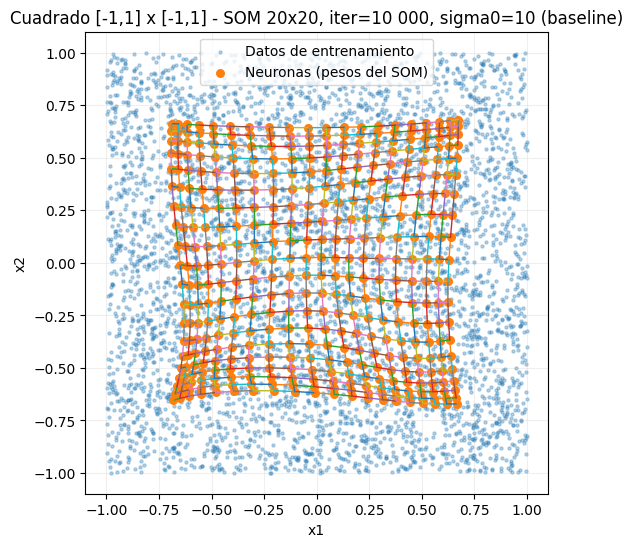


--- Variante: SOM 30x30, iter=15 000, sigma0=12 ---
Iteración 3000/15000 - alpha=0.4094, sigma=9.8254
Iteración 6000/15000 - alpha=0.3352, sigma=8.0444
Iteración 9000/15000 - alpha=0.2744, sigma=6.5862
Iteración 12000/15000 - alpha=0.2247, sigma=5.3923
Iteración 15000/15000 - alpha=0.1840, sigma=4.4148


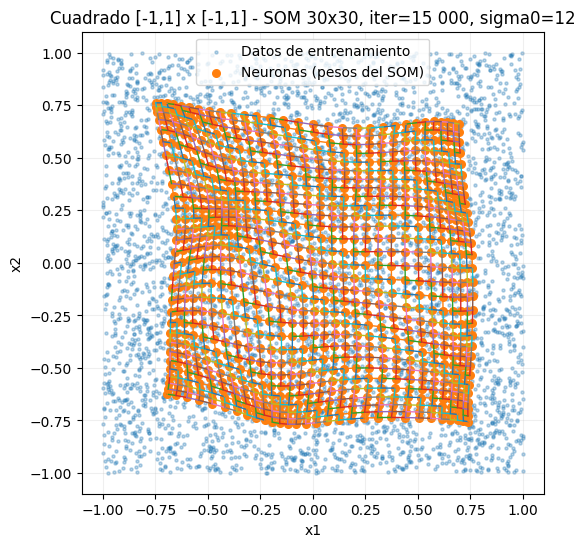



================= Triángulo equilátero =================

--- Variante: SOM 10x10, iter=5 000, sigma0=5 ---
Iteración 1000/5000 - alpha=0.4094, sigma=4.0945
Iteración 2000/5000 - alpha=0.3352, sigma=3.3523
Iteración 3000/5000 - alpha=0.2745, sigma=2.7446
Iteración 4000/5000 - alpha=0.2247, sigma=2.2471
Iteración 5000/5000 - alpha=0.1840, sigma=1.8398


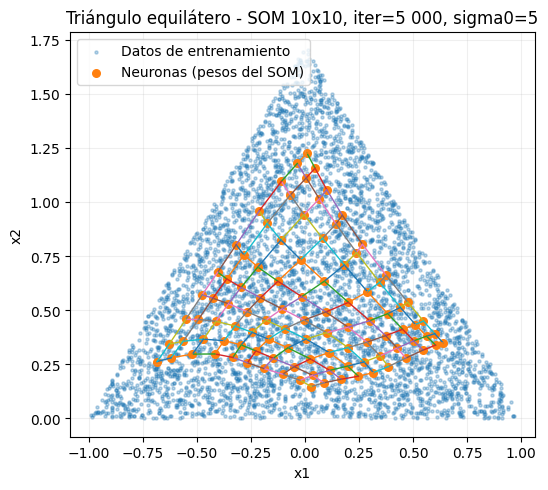


--- Variante: SOM 20x20, iter=10 000, sigma0=10 (baseline) ---
Iteración 2000/10000 - alpha=0.4094, sigma=8.1881
Iteración 4000/10000 - alpha=0.3352, sigma=6.7039
Iteración 6000/10000 - alpha=0.2744, sigma=5.4887
Iteración 8000/10000 - alpha=0.2247, sigma=4.4937
Iteración 10000/10000 - alpha=0.1840, sigma=3.6792


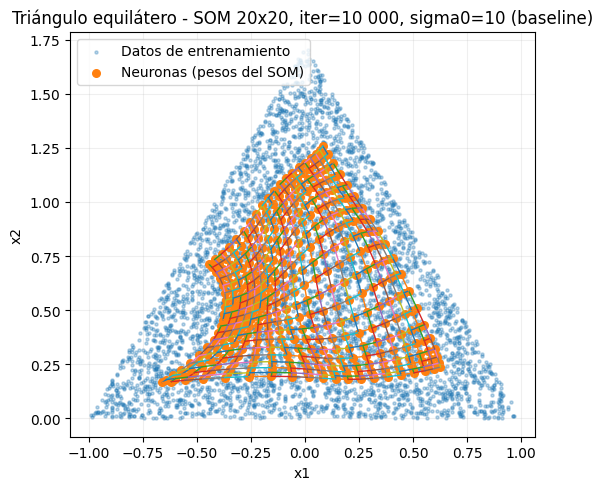


--- Variante: SOM 30x30, iter=15 000, sigma0=12 ---
Iteración 3000/15000 - alpha=0.4094, sigma=9.8254
Iteración 6000/15000 - alpha=0.3352, sigma=8.0444
Iteración 9000/15000 - alpha=0.2744, sigma=6.5862
Iteración 12000/15000 - alpha=0.2247, sigma=5.3923
Iteración 15000/15000 - alpha=0.1840, sigma=4.4148


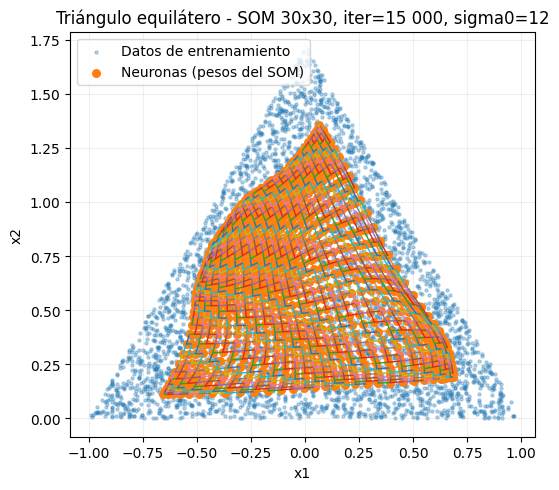

In [7]:
# ==== Experimentos SOM con varias variantes por figura (círculo, cuadrado, triángulo) ====

n_samples = 5000

# Definimos las distribuciones
shapes = [
    ("Círculo unitario", sample_uniform_circle),
    ("Cuadrado [-1,1] x [-1,1]", sample_uniform_square),
    ("Triángulo equilátero", sample_uniform_triangle),
]

# Variantes de SOM a probar en cada distribución
variants = [
    {
        "label": "SOM 10x10, iter=5 000, sigma0=5",
        "m": 10,
        "n": 10,
        "n_iterations": 5_000,
        "alpha0": 0.5,
        "sigma0": 5.0,
    },
    {
        "label": "SOM 20x20, iter=10 000, sigma0=10 (baseline)",
        "m": 20,
        "n": 20,
        "n_iterations": 10_000,
        "alpha0": 0.5,
        "sigma0": 10.0,
    },
    {
        "label": "SOM 30x30, iter=15 000, sigma0=12",
        "m": 30,
        "n": 30,
        "n_iterations": 15_000,
        "alpha0": 0.5,
        "sigma0": 12.0,
    },
]

for shape_name, sampler in shapes:
    print(f"\n\n================= {shape_name} =================")
    data = sampler(n_samples)

    for v in variants:
        print(f"\n--- Variante: {v['label']} ---")
        som = SOM2D(
            m=v["m"],
            n=v["n"],
            input_dim=2,
            n_iterations=v["n_iterations"],
            alpha0=v["alpha0"],
            sigma0=v["sigma0"],
        )

        som.train(data, verbose=True)

        plot_title = (
            f"{shape_name} - {v['label']}"
        )
        plot_som_topology(
            som,
            data,
            title=plot_title,
            data_alpha=0.3,
        )


### Conclusiones sobre los experimentos con SOM

Se evaluó el comportamiento de un mapa de Kohonen bidimensional sobre tres
distribuciones uniformes (círculo unitario, cuadrado $[-1,1]^2$ y triángulo
equilátero) y tres configuraciones de red:

- SOM pequeño: $10 \times 10$, $5\,000$ iteraciones, $\sigma_0 = 5$.
- SOM intermedio (baseline): $20 \times 20$, $10\,000$ iteraciones, $\sigma_0 = 10$.
- SOM grande: $30 \times 30$, $15\,000$ iteraciones, $\sigma_0 = 12$.

En todos los casos el mapa preserva la topología: la malla de neuronas se
mantiene continua y sin cruces bruscos, y se deforma para aproximar el soporte
de los datos.

#### Círculo unitario

- El SOM pequeño produce una malla relativamente “rígida”: cubre el interior del
  disco pero la grilla se mantiene bastante cuadrada y la aproximación de la
  frontera circular es gruesa.
- El SOM intermedio mejora la adaptación a la forma del círculo: los bordes de
  la malla se curvan y aparecen anillos de neuronas más pegados a la frontera.
- El SOM grande logra la mayor resolución espacial. La malla se curva de forma
  suave y hay más neuronas ocupando regiones periféricas, lo que permite
  distinguir mejor el gradiente de densidad entre el centro y el borde. A
  cambio, el entrenamiento es más costoso y la malla puede mostrar pequeñas
  ondulaciones locales.

#### Cuadrado $[-1,1]^2$

- En el cuadrado, los tres SOM convergen a mallas que se asemejan a una grilla
  rectangular. La versión $10 \times 10$ cubre bien el área, pero deja zonas
  poco representadas en los vértices.
- El SOM $20 \times 20$ ofrece un compromiso razonable: la malla es casi
  regular y las neuronas se distribuyen de manera bastante uniforme sobre toda
  la superficie.
- Con el SOM $30 \times 30$ se consigue la cobertura más uniforme del cuadrado,
  aunque se observan pequeñas deformaciones en los bordes debido a la
  interacción entre un $\sigma_0$ relativamente grande y un número alto de
  iteraciones.

#### Triángulo equilátero

- Para el triángulo la geometría es más exigente: la malla debe plegarse para
  seguir los lados inclinados y el vértice superior.
- El SOM pequeño tiende a concentrar neuronas en la base y en la región central,
  dejando el vértice superior menos representado y produciendo una malla algo
  “achatada”.
- El SOM intermedio mejora la cobertura del interior del triángulo, aunque
  todavía se observa cierta pérdida de resolución en los vértices.
- El SOM grande permite seguir con más detalle los lados del triángulo, pero al
  mismo tiempo puede acumular neuronas en zonas de mayor densidad de muestras,
  dejando algunos extremos algo menos poblados si el entrenamiento no es lo
  suficientemente largo.

#### Comparación general

- Aumentar el tamaño del mapa ($10 \times 10 \to 30 \times 30$) mejora la
  **resolución** de la representación (más neuronas, más detalle), pero encarece
  el entrenamiento y puede introducir pequeñas **ondas** o deformaciones
  locales si los parámetros de $\alpha(t)$ y $\sigma(t)$ no se ajustan.
- El SOM intermedio $20 \times 20$ ofrece, en estas pruebas, el mejor
  **compromiso** entre calidad del mapa y coste computacional, capturando la
  forma global de las distribuciones sin distorsiones graves.
- Las figuras no rectangulares (círculo y triángulo) evidencian mejor la
  capacidad del SOM para plegarse y aproximar fronteras curvas o con ángulos,
  manteniendo la propiedad de **preservación de vecindad** que caracteriza a los
  mapas de Kohonen.


# 2. Resuelva (aproximadamente) el “Traveling salesman problem” para 200 ciudades con una red de Kohonen.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Para reproducibilidad, si querés:
np.random.seed(42)


### Red de Kohonen 1D en anillo para el Traveling Salesman Problem (TSP)

El objetivo del TSP es encontrar un recorrido cerrado que visite una vez cada ciudad  
minimizando la longitud total del camino. Si denotamos por  
$c_1, \dots, c_N \in \mathbb{R}^2$ las posiciones de las $N$ ciudades,  
un tour es una permutación $\pi$ de $\{1,\dots,N\}$, y su longitud es

$$
L(\pi) \;=\; \sum_{i=1}^{N} 
\left\| c_{\pi(i)} - c_{\pi(i+1)} \right\|,
\qquad
\pi(N+1) = \pi(1).
$$

Este problema es NP–duro, por lo que se utilizan métodos aproximados.  
Una alternativa es usar un **mapa de Kohonen 1D en forma de anillo**, que se deforma
para “rodear” las ciudades.

---

### Representación de la red

La clase `TSPSOM` implementa una red de Kohonen con:

- $K = \texttt{n\_neurons}$ neuronas dispuestas en un **anillo** (índices $k = 0,\dots,K-1$).
- Cada neurona $k$ tiene un vector de pesos
  $$
  \mathbf{w}_k(t) \in \mathbb{R}^2,
  $$
  que representa una posición en el mismo plano que las ciudades.
- El conjunto de pesos en el tiempo $t$ es
  $$
  W(t) = \{ \mathbf{w}_0(t), \dots, \mathbf{w}_{K-1}(t) \}.
  $$

Inicialmente, los pesos se eligen aleatoriamente en el cuadrado $[0,1]^2$, y durante el
entrenamiento el anillo se va adaptando a la nube de ciudades.

---

### Unidad de Mejor Ajuste (BMU)

Dada una ciudad $\mathbf{x} \in \mathbb{R}^2$, la red busca la **Best Matching Unit (BMU)**:
la neurona cuyos pesos están más cerca de $\mathbf{x}$ en norma euclídea. Es decir,

$$
k^\ast(\mathbf{x}) 
\;=\; \underset{k \in \{0,\dots,K-1\}}{\arg\min}\,
\left\| \mathbf{x} - \mathbf{w}_k(t) \right\|^2.
$$

En el código, esto se implementa en el método `_find_bmu_idx`.

---

### Topología en anillo y distancia circular

Las neuronas no solo tienen pesos en el espacio de ciudades, sino también una
posición en el **índice topológico** del anillo:
$$
k = 0, 1, \dots, K-1.
$$

La distancia entre neuronas en esa topología circular se define como

$$
d_{\text{ring}}(k, k^\ast)
\;=\;
\min\left( \,|k - k^\ast|,\; K - |k - k^\ast| \right),
$$

lo que refleja la estructura de anillo (la neurona $0$ es vecina de la neurona $K-1$).

Esta distancia se usa para definir la vecindad de la BMU sobre el anillo.

---

### Decaimiento de la tasa de aprendizaje y del radio de vecindad

La red utiliza una tasa de aprendizaje $\alpha(t)$ y un radio de vecindad $\sigma(t)$
que decrecen exponencialmente con el tiempo:

$$
\alpha(t) = \alpha_0 \, e^{-t / T}, \qquad
\sigma(t) = \sigma_0 \, e^{-t / T},
$$

donde:

- $\alpha_0 = \texttt{alpha0}$ es la tasa de aprendizaje inicial,
- $\sigma_0 = \texttt{sigma0}$ es el radio inicial de vecindad,
- $T = \texttt{n\_iterations}$ es el número total de iteraciones.

Al inicio, la actualización es más “global” (gran $\sigma(t)$), y hacia el final se vuelve
más “local”, afinando la solución.

---

### Función de vecindad gaussiana en el anillo

Para una ciudad $\mathbf{x}$ con BMU $k^\ast$, la **función de vecindad** entre la BMU
y una neurona $k$ viene dada por:

$$
h_{k^\ast, k}(t)
=
\exp\left(
  -\frac{d_{\text{ring}}(k, k^\ast)^2}{2 \, \sigma(t)^2}
\right).
$$

Esta función es máxima en la BMU ($k = k^\ast$) y decrece suavemente a medida que
$k$ se aleja sobre el anillo, controlada por $\sigma(t)$.

---

### Regla de aprendizaje de Kohonen

En cada iteración $t$ del entrenamiento:

1. Se selecciona una ciudad $\mathbf{x}$ al azar del conjunto de ciudades.
2. Se calcula la BMU $k^\ast(\mathbf{x})$.
3. Se actualiza el vector de pesos de cada neurona $k$ según:

$$
\mathbf{w}_k(t+1)
=
\mathbf{w}_k(t)
+
\alpha(t)\, h_{k^\ast, k}(t)\,
\bigl(
  \mathbf{x} - \mathbf{w}_k(t)
\bigr).
$$

Esta regla mueve la BMU y sus vecinas en el anillo hacia la ciudad $\mathbf{x}$,
haciendo que la curva formada por los $\mathbf{w}_k(t)$ se adapte progresivamente a la
distribución de ciudades. Como la topología es 1D circular, la red tiende a formar
un **circuito cerrado** que atraviesa la región donde se encuentran las ciudades.

---

### Construcción del recorrido TSP aproximado

Una vez entrenada la red, se obtiene un recorrido TSP aproximado a partir de la
correspondencia entre ciudades y neuronas:

1. Para cada ciudad $\mathbf{c}_i$, se calcula el índice de la BMU:

   $$
   k_i = k^\ast(\mathbf{c}_i).
   $$

2. Se forman pares $(k_i, i)$ y se ordenan según $k_i$:

   $$
   (k_{(1)}, i_{(1)}), \dots, (k_{(N)}, i_{(N)}) 
   \quad \text{con} \quad
   k_{(1)} \le k_{(2)} \le \dots \le k_{(N)}.
   $$

3. El orden de ciudades

   $$
   \pi = \bigl( i_{(1)}, i_{(2)}, \dots, i_{(N)} \bigr)
   $$

   define un tour cerrado al volver de $i_{(N)}$ a $i_{(1)}$.

Este procedimiento explota la **preservación de vecindad** del mapa de Kohonen:
ciudades que terminan asociadas a neuronas cercanas en el anillo tienden a estar
cercanas en el plano, lo que produce trayectorias razonablemente cortas.

---

### Resumen conceptual

- El TSP se modela mediante una **curva cerrada** (el anillo de neuronas) que se entrena
  para aproximar la distribución de las ciudades.
- La red de Kohonen 1D minimiza de forma no supervisada una combinación de:
  - distancia entre ciudades y neuronas (ajuste de los pesos),
  - suavidad/topología del anillo (vecindad gaussiana).
- El recorrido final se obtiene ordenando las ciudades según la posición de su BMU
  sobre el anillo, dando una solución aproximada al TSP.


In [2]:
class TSPSOM:
    """
    Mapa de Kohonen 1D en forma de anillo para aproximar el TSP.

    - Tenemos n_neurons neuronas dispuestas en un círculo (índices 0..n_neurons-1).
    - Cada neurona tiene un vector de pesos en R^2 que vive en el mismo espacio
      que las ciudades.
    - La vecindad se define sobre el índice circular (distancia en el anillo).
    """

    def __init__(
        self,
        n_neurons: int,
        input_dim: int = 2,
        n_iterations: int = 20_000,
        alpha0: float = 0.8,
        sigma0: float | None = None,
    ):
        """
        Parámetros
        ----------
        n_neurons : cantidad de neuronas en el anillo.
                    Suele tomarse un múltiplo de la cantidad de ciudades
                    (e.g. 5-10 veces más).
        input_dim : dimensión de entrada (para TSP en el plano = 2).
        n_iterations : número total de iteraciones de entrenamiento.
        alpha0 : tasa de aprendizaje inicial.
        sigma0 : radio de vecindad inicial en el anillo.
                 Si es None, se usa n_neurons / 2.
        """
        self.n_neurons = n_neurons
        self.input_dim = input_dim
        self.n_iterations = n_iterations
        self.alpha0 = alpha0
        self.sigma0 = sigma0 if sigma0 is not None else n_neurons / 2.0

        # Pesos iniciales en el cuadrado [0,1] x [0,1]
        # (después se van a adaptar hacia las ciudades reales)
        self.weights = np.random.rand(n_neurons, input_dim)

        # Índices de neuronas (para calcular distancia en el anillo)
        self.neuron_indices = np.arange(n_neurons)

    # ---------- Decaimiento de hiperparámetros ----------

    def _decay_alpha(self, t: int) -> float:
        """
        Tasa de aprendizaje alpha(t) con decaimiento exponencial.
        """
        return self.alpha0 * np.exp(-t / self.n_iterations)

    def _decay_sigma(self, t: int) -> float:
        """
        Radio de vecindad sigma(t) con decaimiento exponencial.
        """
        return self.sigma0 * np.exp(-t / self.n_iterations)

    # ---------- BMU (Best Matching Unit) ----------

    def _find_bmu_idx(self, x: np.ndarray) -> int:
        """
        Dado un vector de entrada x (shape = (input_dim,)),
        devuelve el índice k de la neurona ganadora (BMU).

        La BMU es la neurona cuyo vector de pesos está a menor
        distancia euclídea de x.
        """
        diff = self.weights - x  # shape: (n_neurons, input_dim)
        dist_sq = np.sum(diff**2, axis=1)  # shape: (n_neurons,)
        bmu_idx = np.argmin(dist_sq)
        return bmu_idx

    # ---------- Entrenamiento ----------

    def train(self, cities: np.ndarray, verbose: bool = True) -> None:
        """
        Entrena el SOM sobre el conjunto de ciudades.

        cities: array de shape (N_cities, 2)
        """
        n_cities = cities.shape[0]

        for t in range(self.n_iterations):
            # 1. Elegimos una ciudad aleatoria
            x = cities[np.random.randint(0, n_cities)]

            # 2. BMU para esta ciudad
            bmu_idx = self._find_bmu_idx(x)

            # 3. Hiperparámetros en esta iteración
            alpha_t = self._decay_alpha(t)
            sigma_t = self._decay_sigma(t)

            # 4. Distancia circular en el anillo entre cada neurona y la BMU
            #    dist_ring(k, bmu) = min(|k - bmu|, n_neurons - |k - bmu|)
            dist = np.abs(self.neuron_indices - bmu_idx)
            dist_ring = np.minimum(dist, self.n_neurons - dist)

            # 5. Función de vecindad gaussiana en el anillo
            neighborhood = np.exp(- (dist_ring**2) / (2 * (sigma_t**2)))  # shape: (n_neurons,)

            # 6. Actualización de los pesos (regla de Kohonen)
            self.weights += alpha_t * neighborhood[:, np.newaxis] * (x - self.weights)

            # Progreso
            if verbose and (t + 1) % (self.n_iterations // 5) == 0:
                print(
                    f"Iteración {t + 1}/{self.n_iterations} "
                    f"- alpha={alpha_t:.4f}, sigma={sigma_t:.4f}"
                )

    # ---------- Utilidades ----------

    def get_weights(self) -> np.ndarray:
        """
        Devuelve una copia de los pesos actuales del SOM.
        Shape: (n_neurons, input_dim)
        """
        return self.weights.copy()

    def bmu_indices_for_cities(self, cities: np.ndarray) -> np.ndarray:
        """
        Devuelve, para cada ciudad, el índice de la neurona BMU.

        cities: (N_cities, 2)
        return: (N_cities,) con índices en [0, n_neurons-1]
        """
        bmu_indices = []
        for city in cities:
            bmu_indices.append(self._find_bmu_idx(city))
        return np.array(bmu_indices, dtype=int)

    def get_tour(self, cities: np.ndarray) -> list[int]:
        """
        Construye un recorrido TSP aproximado a partir del SOM entrenado.

        Estrategia:
        - Para cada ciudad, se calcula la BMU (índice k).
        - Se ordenan las ciudades según ese índice k a lo largo del anillo.
        - El resultado es una permutación de los índices de ciudades
          que define un tour cerrado.
        """
        bmu_indices = self.bmu_indices_for_cities(cities)

        # Lista de pares (índice_neurona, índice_ciudad)
        pairs = list(zip(bmu_indices, range(len(cities))))

        # Ordenar por índice de neurona a lo largo del anillo
        pairs.sort(key=lambda p: p[0])

        # Extraer el orden de ciudades
        tour = [city_idx for (_, city_idx) in pairs]
        return tour


### Cálculo y visualización del tour TSP

La función `tour_length` calcula la longitud total de un **tour cerrado** sobre el conjunto de ciudades.  
Dadas las posiciones $\{\mathbf{c}_1, \dots, \mathbf{c}_N\} \subset \mathbb{R}^2$ y un tour
$\pi$ (permutación de $\{1,\dots,N\}$), la longitud se define como

$$
L(\pi)
=
\sum_{i=1}^{N}
\left\|
\mathbf{c}_{\pi(i)} - \mathbf{c}_{\pi(i+1)}
\right\|,
\qquad
\pi(N+1) = \pi(1),
$$

es decir, se suma la distancia euclídea entre ciudades consecutivas y se cierra el ciclo
volviendo de la última ciudad a la primera.

La función `plot_tsp_tour` representa gráficamente este recorrido:

- Dibuja las ciudades como puntos en el plano.
- Traza el tour como una **polilínea cerrada** que conecta las ciudades en el orden dado por $\pi$.
- Opcionalmente, si se pasa una instancia de `TSPSOM`, grafica también el **anillo de neuronas**
  (curva punteada) para visualizar cómo el mapa de Kohonen se adaptó a la distribución de ciudades
  y al recorrido obtenido.


In [3]:
def tour_length(cities: np.ndarray, tour: list[int]) -> float:
    """
    Calcula la longitud total de un tour cerrado sobre las ciudades.

    cities: array (N_cities, 2)
    tour: lista de índices de ciudades (permutación de 0..N-1)
    """
    total = 0.0
    n = len(tour)
    for i in range(n):
        c1 = cities[tour[i]]
        c2 = cities[tour[(i + 1) % n]]  # volver al inicio
        total += np.linalg.norm(c1 - c2)
    return total


def plot_tsp_tour(
    cities: np.ndarray,
    tour: list[int],
    som: TSPSOM | None = None,
    title: str = "Recorrido TSP aproximado con SOM",
) -> None:
    """
    Grafica:
    - Las ciudades como puntos.
    - El recorrido TSP aproximado como una polilínea cerrada.
    - Opcionalmente, el anillo de neuronas del SOM.

    som: instancia entrenada de TSPSOM (opcional).
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Ciudades
    ax.scatter(
        cities[:, 0],
        cities[:, 1],
        s=30,
        label="Ciudades",
    )

    # Recorrido (polilínea cerrada)
    closed_tour = tour + [tour[0]]
    ax.plot(
        cities[closed_tour, 0],
        cities[closed_tour, 1],
        linewidth=1.5,
        marker="o",
        markersize=4,
        label="Recorrido SOM",
    )

    # Anillo de neuronas (opcional, para ver cómo se adaptó)
    if som is not None:
        weights = som.get_weights()
        closed_ring = np.vstack([weights, weights[0:1, :]])  # curva cerrada
        ax.plot(
            closed_ring[:, 0],
            closed_ring[:, 1],
            linestyle="--",
            linewidth=1,
            label="Anillo SOM",
        )

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.2)
    ax.legend()
    plt.show()


### Experimento: aproximación del TSP para 200 ciudades con un SOM en anillo

Para evaluar el desempeño de la red de Kohonen 1D en la aproximación del Traveling Salesman Problem, se generó un conjunto sintético de $N = 200$ ciudades, muestreadas de manera uniforme en el cuadrado $[0,1] \times [0,1]$.

Sobre este conjunto se entrenaron varias instancias de la red `TSPSOM`, variando los hiperparámetros principales:

- el tamaño del mapa $K$ (número de neuronas en el anillo, por ejemplo $K = 2N, 4N, 8N, 16N$),
- la tasa de aprendizaje inicial $\alpha_0$,
- el radio inicial de vecindad $\sigma_0$ (expresado como fracción de $K$ y decreciendo exponencialmente),
- y el número total de iteraciones $T$.

En todos los casos la red mantiene dimensión de entrada $d = 2$ (coordenadas de las ciudades). Tras el entrenamiento, se construyó un recorrido aproximado ordenando las ciudades según el índice de la neurona BMU asociada a cada una. La calidad de la solución se evaluó mediante la longitud total del tour

$$
L(\pi)
=
\sum_{i=1}^{N}
\bigl\|
\mathbf{c}_{\pi(i)} - \mathbf{c}_{\pi(i+1)}
\bigr\|,
\qquad
\pi(N+1) = \pi(1),
$$

comparando, para cada configuración:

- $L_{\text{SOM}}$: longitud del tour inducido por el mapa de Kohonen.
- $L_{\text{rand}}$: longitud de un tour aleatorio (permutación uniforme de las ciudades).

Asimismo, se contabilizó el número de **neuronas activas**, es decir, neuronas a las que quedó asociada al menos una ciudad, como indicador de cuán eficientemente se utiliza el anillo para representar el conjunto de puntos. Para cada corrida se generó una visualización que muestra simultáneamente las ciudades, el tour obtenido y el anillo de neuronas entrenado, lo que permite comparar cualitativamente el efecto de los distintos hiperparámetros sobre la forma del recorrido.


Configuración del experimento TSP-SOM
Número de ciudades      : 200
Se probarán 6 configuraciones de SOM.


>>> Configuración 1: K = 2N,  alpha0=0.5, sigma0 = K/8
    n_neurons   = 400
    n_iterations= 15000
    alpha0      = 0.5
    sigma0      = 50.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 19.1147
Longitud de un tour aleatorio : 103.6554
Mejora relativa vs. aleatorio : 81.56%
Neuronas activas              : 154 / 400
------------------------------------


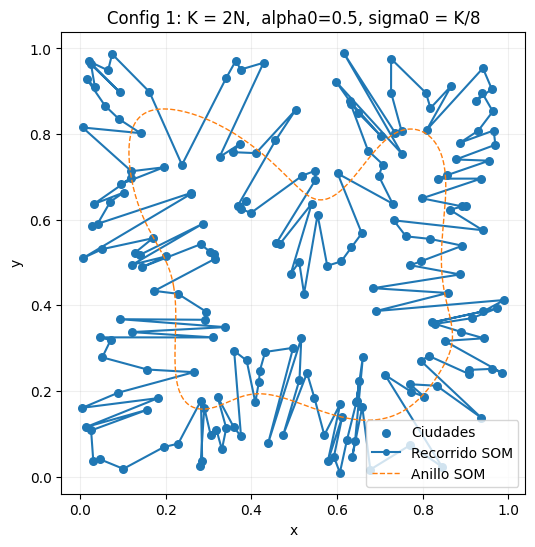


>>> Configuración 2: K = 4N,  alpha0=0.5, sigma0 = K/8
    n_neurons   = 800
    n_iterations= 20000
    alpha0      = 0.5
    sigma0      = 100.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 17.6893
Longitud de un tour aleatorio : 110.1565
Mejora relativa vs. aleatorio : 83.94%
Neuronas activas              : 172 / 800
------------------------------------


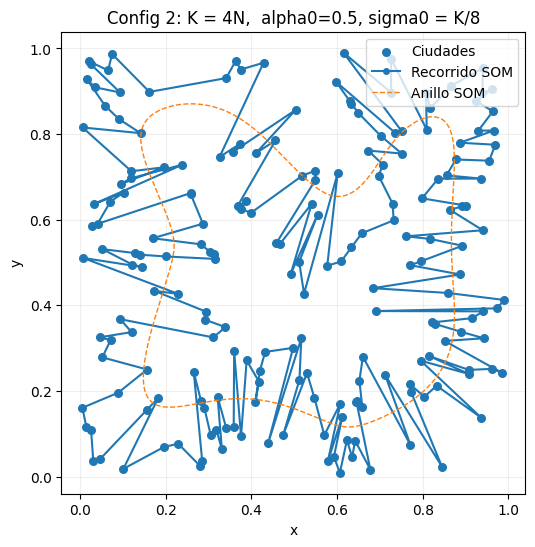


>>> Configuración 3: K = 4N,  alpha0=0.5, sigma0 = K/16
    n_neurons   = 800
    n_iterations= 20000
    alpha0      = 0.5
    sigma0      = 50.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 14.1502
Longitud de un tour aleatorio : 104.1999
Mejora relativa vs. aleatorio : 86.42%
Neuronas activas              : 183 / 800
------------------------------------


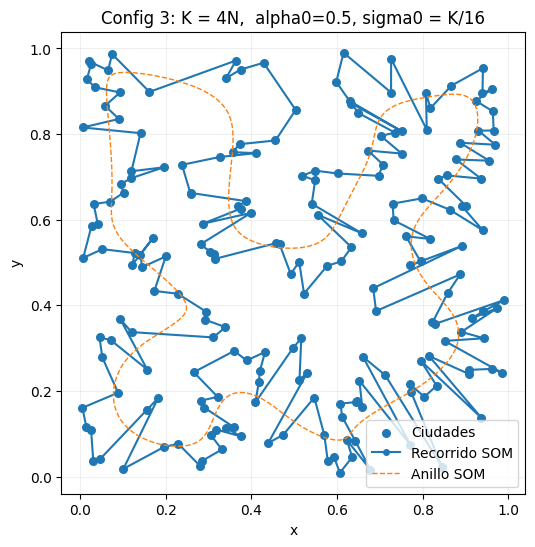


>>> Configuración 4: K = 8N,  alpha0=0.5, sigma0 = K/8
    n_neurons   = 1600
    n_iterations= 20000
    alpha0      = 0.5
    sigma0      = 200.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 17.9824
Longitud de un tour aleatorio : 108.9658
Mejora relativa vs. aleatorio : 83.50%
Neuronas activas              : 186 / 1600
------------------------------------


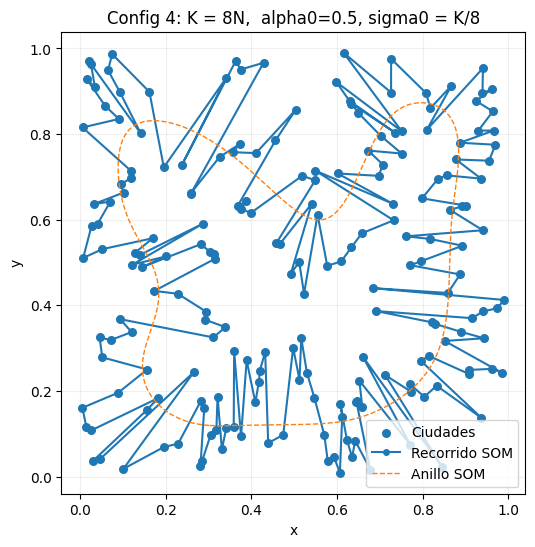


>>> Configuración 5: K = 8N,  alpha0=0.8, sigma0 = K/8
    n_neurons   = 1600
    n_iterations= 30000
    alpha0      = 0.8
    sigma0      = 200.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 19.5579
Longitud de un tour aleatorio : 108.6773
Mejora relativa vs. aleatorio : 82.00%
Neuronas activas              : 188 / 1600
------------------------------------


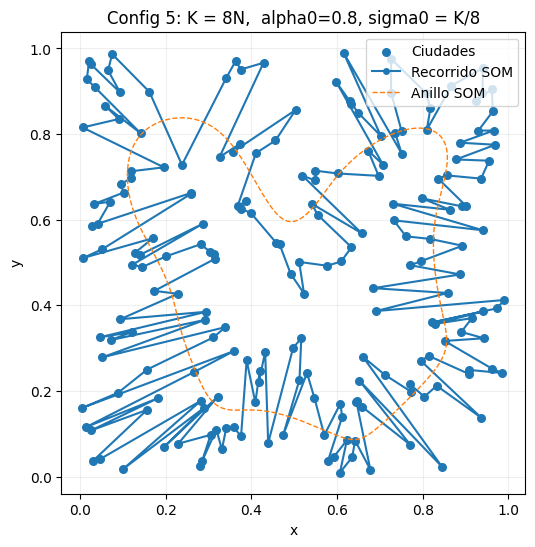


>>> Configuración 6: K = 16N, alpha0=0.8, sigma0 = K/8
    n_neurons   = 3200
    n_iterations= 30000
    alpha0      = 0.8
    sigma0      = 400.00

Entrenando SOM para el TSP...

------------ Resultados ------------
Longitud del tour SOM         : 17.9047
Longitud de un tour aleatorio : 105.7174
Mejora relativa vs. aleatorio : 83.06%
Neuronas activas              : 191 / 3200
------------------------------------


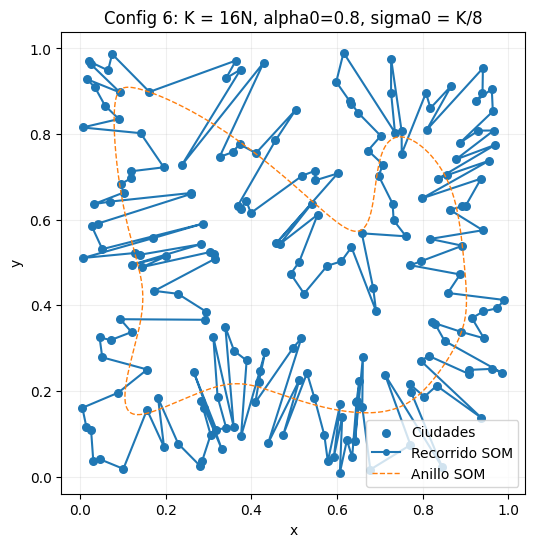


Mejor configuración según L_som:
Label                : K = 4N,  alpha0=0.5, sigma0 = K/16
L_som                : 14.1502
Mejora vs aleatorio  : 86.42%
Neuronas activas     : 183 / 800


In [8]:
# ==== Experimento: TSP aproximado para 200 ciudades con varias configuraciones de SOM ==== 

np.random.seed(42)

# 1. Generamos 200 ciudades aleatorias en el cuadrado [0,1] x [0,1]
n_cities = 200
cities = np.random.rand(n_cities, 2)

# 2. Definimos un conjunto de configuraciones a probar
configs = [
    {
        "label": "K = 2N,  alpha0=0.5, sigma0 = K/8",
        "n_neurons": 2 * n_cities,
        "n_iterations": 15_000,
        "alpha0": 0.5,
        "sigma0_factor": 1/8,
    },
    {
        "label": "K = 4N,  alpha0=0.5, sigma0 = K/8",
        "n_neurons": 4 * n_cities,
        "n_iterations": 20_000,
        "alpha0": 0.5,
        "sigma0_factor": 1/8,
    },
    {
        "label": "K = 4N,  alpha0=0.5, sigma0 = K/16",
        "n_neurons": 4 * n_cities,
        "n_iterations": 20_000,
        "alpha0": 0.5,
        "sigma0_factor": 1/16,
    },
    {
        "label": "K = 8N,  alpha0=0.5, sigma0 = K/8",
        "n_neurons": 8 * n_cities,
        "n_iterations": 20_000,
        "alpha0": 0.5,
        "sigma0_factor": 1/8,
    },
    {
        "label": "K = 8N,  alpha0=0.8, sigma0 = K/8",
        "n_neurons": 8 * n_cities,
        "n_iterations": 30_000,
        "alpha0": 0.8,
        "sigma0_factor": 1/8,
    },
    {
        "label": "K = 16N, alpha0=0.8, sigma0 = K/8",
        "n_neurons": 16 * n_cities,
        "n_iterations": 30_000,
        "alpha0": 0.8,
        "sigma0_factor": 1/8,
    },
]

print("============================================")
print("Configuración del experimento TSP-SOM")
print(f"Número de ciudades      : {n_cities}")
print("Se probarán", len(configs), "configuraciones de SOM.")
print("============================================\n")

results = []

for cfg_idx, cfg in enumerate(configs, start=1):
    n_neurons = cfg["n_neurons"]
    n_iterations = cfg["n_iterations"]
    alpha0 = cfg["alpha0"]
    sigma0 = cfg["sigma0_factor"] * n_neurons

    print(f"\n>>> Configuración {cfg_idx}: {cfg['label']}")
    print(f"    n_neurons   = {n_neurons}")
    print(f"    n_iterations= {n_iterations}")
    print(f"    alpha0      = {alpha0}")
    print(f"    sigma0      = {sigma0:.2f}\n")

    tsp_som = TSPSOM(
        n_neurons=n_neurons,
        input_dim=2,
        n_iterations=n_iterations,
        alpha0=alpha0,
        sigma0=sigma0,
    )

    print("Entrenando SOM para el TSP...\n")
    tsp_som.train(cities, verbose=False)

    # Tour SOM
    tour = tsp_som.get_tour(cities)
    L_som = tour_length(cities, tour)

    # Tour aleatorio para comparar
    rand_tour = list(np.random.permutation(n_cities))
    L_rand = tour_length(cities, rand_tour)

    # Neuronas activas
    bmu_indices = tsp_som.bmu_indices_for_cities(cities)
    unique_bmus = np.unique(bmu_indices)

    mejora = (L_rand - L_som) / L_rand * 100.0

    print("------------ Resultados ------------")
    print(f"Longitud del tour SOM         : {L_som:.4f}")
    print(f"Longitud de un tour aleatorio : {L_rand:.4f}")
    print(f"Mejora relativa vs. aleatorio : {mejora:.2f}%")
    print(f"Neuronas activas              : {len(unique_bmus)} / {n_neurons}")
    print("------------------------------------")

    # Guardamos para comparar luego
    results.append({
        "label": cfg["label"],
        "n_neurons": n_neurons,
        "n_iterations": n_iterations,
        "alpha0": alpha0,
        "sigma0": sigma0,
        "L_som": L_som,
        "L_rand": L_rand,
        "mejora": mejora,
        "n_active": len(unique_bmus),
        "tour": tour,
        "som": tsp_som,
    })

    # Gráfico para esta configuración
    plot_tsp_tour(
        cities,
        tour,
        som=tsp_som,
        title=f"Config {cfg_idx}: {cfg['label']}",
    )

# Elegir la mejor configuración (mínimo L_som) y resumir
best = min(results, key=lambda r: r["L_som"])
print("\n============================================")
print("Mejor configuración según L_som:")
print(f"Label                : {best['label']}")
print(f"L_som                : {best['L_som']:.4f}")
print(f"Mejora vs aleatorio  : {best['mejora']:.2f}%")
print(f"Neuronas activas     : {best['n_active']} / {best['n_neurons']}")
print("============================================")
